# 1. Imports


## 1.1. Deep Learning Imports

In [1]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Conv3D, MaxPool3D, BatchNormalization, Rescaling
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model#
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 1.2. Additional Imports

In [2]:
import os, sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
from google.colab import drive
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# 2. Read Dataset


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cd '/content/drive/MyDrive/NASA_Data'

In [5]:
!ls -ltr '/content/drive/MyDrive/NASA_Data'

total 12026308
-rw------- 1 root root 5765554176 Jul  9 21:52 trmm_view_db_v4.h5
-rw------- 1 root root      22861 Oct 18 01:53 build_model_3D.py
-rw------- 1 root root 6549358080 Nov 13 14:57 trmm_view_db_v6.1.h5
drwx------ 2 root root       4096 Nov 29 14:03 Models


In [6]:
f = h5py.File('/content/drive/MyDrive/NASA_Data/trmm_view_db_v6.1.h5', 'r')
with f:

    # Print top-level keys
    print("Top-level keys:", list(f.keys()))

    # Access a dataset
    dataset = f['views'][:]

    # Read selected data
    partial_data = dataset[0]

    # Print the selected data
    print("Selected data:", partial_data.shape)
    print("Full data size:", dataset.shape)

Top-level keys: ['landocean_mask', 'views']
Selected data: (16, 16, 22)
Full data size: (144739, 16, 16, 22)


In [7]:
parameters = np.array([
    "TMI 37 GHz PCT",  # 0
    "TMI 85 GHz PCT",  # 1
    "VIRS Ch4 IR Tb",  # 2
    # "TMI 10 GHz PCT",  # 3
    # "TMI 19 GHz PCT",  # 4
    "TMI Precipitable Water",  # 5
    "TMI Ice Water Path",  # 6
    "TMI Rain",  # 7
    "TMI Cloud Liquid Path",  # 8
    "TMI Rain Water Path",  # 9
    "TMI Wind",  # 10
    "PR Near SFC Reflectivity",# 11
    "PR Rain Type", # 12
    "PR Storm Height", # 13
    "PR Rain", # 14
    "PR Precipitation", # 15
    "LIS FED (reprocessed data)",  # 16
    # "LIS FED (original data)",  # 17
    "LIS Viewtime",  # 18
    "Longitude", #  19
    "Latitude", # 20
    "Land Mask" # 21
])

In [8]:
tag = '_v5_freeze_off'

# 3. Helper Functions

In [9]:
def standardize(X, verbose=True):
    scaler = StandardScaler()
    X1 = X.reshape(-1, 16 * 16 * 8)
    X1 = scaler.fit_transform(X1)
    X1 = X1.reshape(-1, 16, 16, 8)
    if verbose:
        print("Final X shape", X1.shape)
    return X1

def compute_metrics(y_true, y_predicted):
    '''
    ## Compute the usual metrics
    '''
    mse = mean_squared_error(y_true, y_predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_predicted)
    return mse, rmse, mae

In [10]:
def prepare_train_data(dataset, freeze_filter=True, verbose=True):
    # Remove irrelevant columns
    content = dataset[:,:,:,[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,18,19,20,21]]

    # Retain relevant columns and indeces
    collist = [0, 1, 2, 10, 11, 14, 15, 18]
    testind = 100000 # filter for all images from 100k indices forward

    # filter for all negative values for all predictors above
    content2 = np.where(content[:testind,:,:,collist]<0, np.nan, content[:testind,:,:,collist])
    if verbose:
        print(content2.shape)

    # Create a mask for non-NaN values
    mask = ~np.isnan(content2).any(axis=(1,2,3))

    # Apply the mask to keep only samples without NaN values
    content3 = content2[mask]

    samples_kept = np.where(mask)[0]
    if verbose:
        print("Samples kept:",len(samples_kept), "Samples Lost:", len(content2)-len(samples_kept))

    # filter for zero filter for TMI37, TMI85 and VIRS
    zerolst = [0,1,2]
    content4 = np.where(content3[:,:,:,zerolst] == 0, np.nan, content3[:,:,:,zerolst])

    # Create a mask for non-NaN values
    zmask = ~np.isnan(content4).any(axis=(1,2,3))

    # Apply the mask to keep only samples without NaN values
    content5 = content4[zmask]

    samples_kept2 = np.where(zmask)[0]
    if verbose:
        print("Samples kept:",len(samples_kept2), "Samples Lost:", content4.shape[0]-len(samples_kept2))

    # concatenate latlong to this data
    content_ll = content[samples_kept2,:,:,16:18]
    if verbose:
        print("shape of latlong",content_ll.shape)

    content_right = content3[samples_kept2,:,:,3:]
    if verbose:
        print("shape of right columns",content_right.shape)

    # create final dataset that has all attributes needed
    content_wzmask = np.concatenate((content5, content_right, content_ll), axis=3)
    if verbose:
        print("shape of zmasked and neg filtered", content_wzmask.shape)

    if freeze_filter:
        # Apply freeze filter if enabled
        if verbose:
            print("Before freeze filter:", content_wzmask[:, :, :, 0].shape)
        freeze = np.any(content_wzmask[:, :, :, 0] >= 273.15, axis=(1, 2))
        content_wzmask = content_wzmask[~freeze]
        if verbose:
            print("After applying freeze filter (TMI37 < 273.15):", content_wzmask.shape)

    # Separate features (X) and target (y)
    X = content_wzmask[:, :, :, 1:]
    y = content_wzmask[:, :, :, 0]

    return X, y

In [11]:
def prepare_test_data(dataset, freeze_filter=False, verbose=True):
    # Remove irrelevant columns
    content = dataset[:,:,:,[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,18,19,20,21]]

    # Retain relevant columns and indeces
    collist = [0, 1, 2, 10, 11, 14, 15, 18]
    testind = 100000 # filter for all images from 100k indices forward

    # filter for all negative values for all predictors above
    content2 = np.where(content[testind:,:,:,collist]<0, np.nan, content[testind:,:,:,collist])
    if verbose:
        print(content2.shape)

    # Create a mask for non-NaN values
    mask = ~np.isnan(content2).any(axis=(1,2,3))

    # Apply the mask to keep only samples without NaN values
    content3 = content2[mask]

    samples_kept = np.where(mask)[0]
    if verbose:
        print("Samples kept:",len(samples_kept), "Samples Lost:", len(content2)-len(samples_kept))

    # filter for zero filter for TMI37, TMI85 and VIRS
    zerolst = [0,1,2]
    content4 = np.where(content3[:,:,:,zerolst] == 0, np.nan, content3[:,:,:,zerolst])

    # Create a mask for non-NaN values
    zmask = ~np.isnan(content4).any(axis=(1,2,3))

    # Apply the mask to keep only samples without NaN values
    content5 = content4[zmask]

    samples_kept2 = np.where(zmask)[0]
    if verbose:
        print("Samples kept:",len(samples_kept2), "Samples Lost:", content4.shape[0]-len(samples_kept2))

    # concatenate latlong to this data
    content_ll = content[samples_kept2,:,:,16:18]
    if verbose:
        print("shape of latlong",content_ll.shape)

    content_right = content3[samples_kept2,:,:,3:]
    if verbose:
        print("shape of right columns",content_right.shape)

    # create final dataset that has all attributes needed
    content_wzmask = np.concatenate((content5, content_right, content_ll), axis=3)
    if verbose:
        print("shape of zmasked and neg filtered", content_wzmask.shape)

    if freeze_filter:
        # Apply freeze filter if enabled
        if verbose:
            print("Before freeze filter:", content_wzmask[:, :, :, 0].shape)
        freeze = np.any(content_wzmask[:, :, :, 0] >= 273.15, axis=(1, 2))
        content_wzmask = content_wzmask[~freeze]
        if verbose:
            print("After applying freeze filter (TMI37 < 273.15):", content_wzmask.shape)

    # Separate features (X) and target (y)
    X = content_wzmask[:, :, :, 1:]
    y = content_wzmask[:, :, :, 0]

    return X, y

# 4. Train Model

## Load Train Data

In [12]:
collist = [0, 1, 2, 10, 11, 14, 15, 18]

In [ ]:
X, y = prepare_train_data(dataset, freeze_filter=False)
X = X[:,:,:,:-2] # no latlong

(100000, 16, 16, 8)
Samples kept: 26567 Samples Lost: 73433
Samples kept: 14225 Samples Lost: 12342
shape of latlong (14225, 16, 16, 2)
shape of right columns (14225, 16, 16, 5)
shape of zmasked and neg filtered (14225, 16, 16, 10)


### Train/Test Split

In [15]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

## 4.2. Build Model - Revised CNN

The latest CNN model removes some features added in previous models (l2 regularization, PreLU) that had a negligible or detrimental effect to accuracy. Instead, a simpler architecture is used with a focus on optimal hyperparameters (learning rate, batch size, kernel_size) to combat overfitting and inaccuracy at lower temperatures.

In [16]:
def build_model_cnn(x_train, x_val, y_train, y_val, tag,
                    layers=3,
                    kernel_size=4,
                    epochs=200,
                    learning_rate=0.00008):
    """
    Function to build and train a CNN model with a Conv2D output layer.

    Parameters:
    - x_train, x_val, y_train, y_val: Preprocessed training and validation datasets.
    - tag: Identifier for the model.
    - layers: Number of convolutional layers to include.
    - kernel_size: Size of the convolutional kernel.
    - epochs: Number of training epochs.
    - learning_rate: Learning rate for the optimizer.

    Returns:
    - model: The trained model.
    - history: Training history.
    """

    model = Sequential()
    for i in range(layers):
        filters = 32 * (2 ** i)  # Double the filters with each layer
        model.add(Conv2D(filters, (kernel_size, kernel_size), activation='relu', padding='same'))
        model.add(BatchNormalization())

    model.add(Conv2D(1, (kernel_size, kernel_size), activation='linear', padding='same'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Train the model
    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=16,
                        validation_data=(x_val, y_val))

    # Function to plot training history
    def plot_history(history):
        fig, axs = plt.subplots(2, figsize=(12, 8))
        axs[0].plot(history.history['loss'], label='Train Loss')
        axs[0].plot(history.history['val_loss'], label='Validation Loss')
        axs[0].set_title('Loss Over Epochs')
        axs[0].legend()

        axs[1].plot(history.history['root_mean_squared_error'], label='Train RMSE')
        axs[1].plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
        axs[1].set_title('RMSE Over Epochs')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

    plot_history(history)

    # Evaluate the model
    test_loss, test_rmse = model.evaluate(x_val, y_val)
    print(f"Validation Loss: {test_loss:.4f}")
    print(f"Validation RMSE: {test_rmse:.4f}")

    model_save_path = f"/content/drive/MyDrive/NASA_Data/Models/{tag}_cnn_model.h5"
    model.save(model_save_path)

    # Return the trained model and history
    return model, history


Epoch 1/200
712/712 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 65684.3438 - root_mean_squared_error: 256.2438 - val_loss: 49555.5820 - val_root_mean_squared_error: 222.6108
Epoch 2/200
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 48942.7266 - root_mean_squared_error: 221.1561 - val_loss: 33840.0742 - val_root_mean_squared_error: 183.9567
Epoch 3/200
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 31730.0508 - root_mean_squared_error: 178.0124 - val_loss: 20377.0371 - val_root_mean_squared_error: 142.7482
Epoch 4/200
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 17120.4336 - root_mean_squared_error: 130.6823 - val_loss: 10364.8730 - val_root_mean_squared_error: 101.8080
Epoch 5/200
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7374.6572 - root_mean_squared_error: 85.6844 - val_loss: 3925.2507 - val_root_mean_squared_error: 62.6518
Epoch 6/200
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2343.7649 - root_mean_squared_error: 48.2279 - val_loss: 1071.7605 - val_root_mean_squa

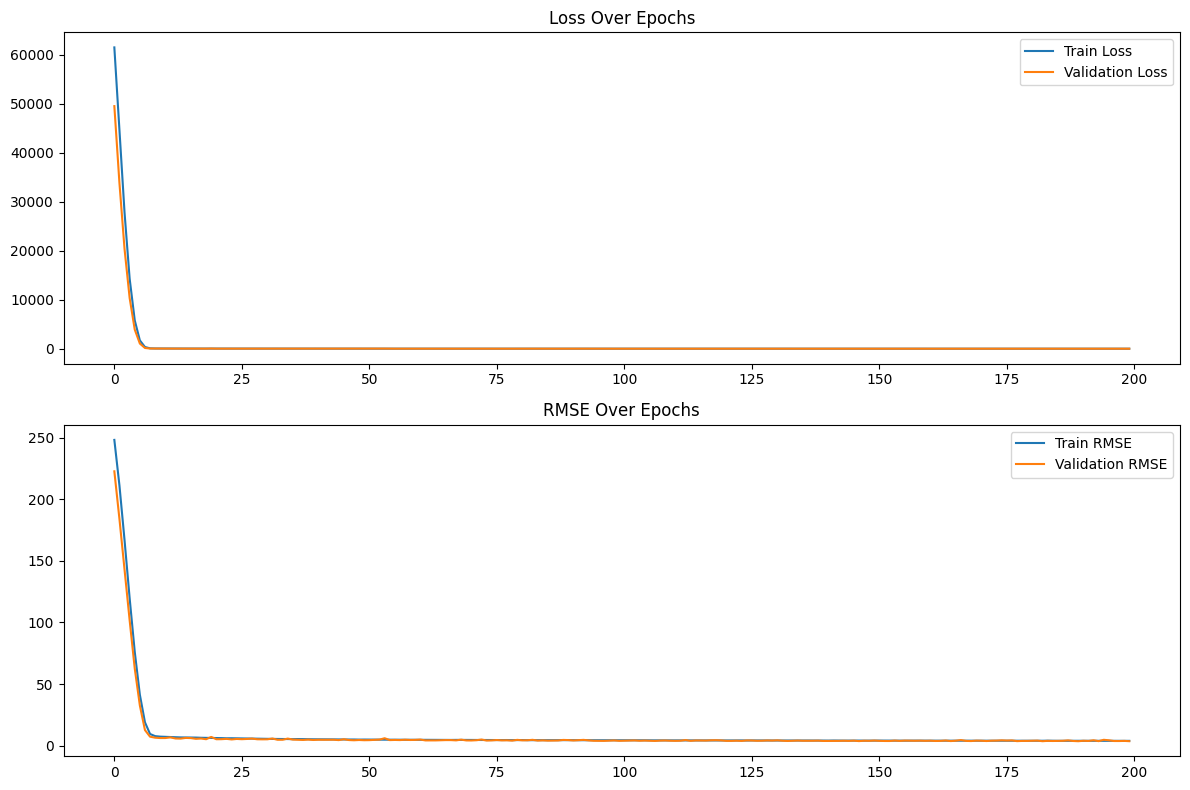

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 13.3851 - root_mean_squared_error: 3.6573


Validation Loss: 13.9393
Validation RMSE: 3.7335


In [17]:
model, history = build_model_cnn(x_train, x_val, y_train, y_val, tag,
                                 layers=3,
                                 kernel_size=4,
                                 epochs=200,
                                 learning_rate=0.00008)

## 4.3 Validate Data

In [18]:
def run_test_eval(model, label="CNN Model V5"):
  preds = model.predict(x_val, verbose=False).ravel()
  acts = y_val.ravel()
  res=acts-preds
  n=y_val.shape[0]
  mse, rmse1,mae = compute_metrics(preds, acts)
  print("Model Evaluation:\n","Model Description: ",label)
  print(f'# of 16x16 images, n= {n:,}')
  print('MSE  = {0:6.2f}'.format(mse))
  print('RMSE = {0:6.2f}'.format(rmse1))
  print('MAE  = {0:6.2f}'.format(mae))

  return mse, rmse1, mae, label

In [19]:
mse1, rmse1, mae1, label1 = run_test_eval(model,label="CNN Model V5, LR = 0.00008")

Model Evaluation:
 Model Description:  CNN Model V5, LR = 0.00008
# of 16x16 images, n= 2,845
MSE  =  13.94
RMSE =   3.73
MAE  =   2.71


# 5. Evaluate Model

## 5.1. Load Test Data


### Unload X and y

In [20]:
del X
del y

### Load Data

In [21]:
X, y = prepare_test_data(dataset, freeze_filter=False)
X = X[:,:,:,:-2]

(44739, 16, 16, 8)
Samples kept: 11334 Samples Lost: 33405
Samples kept: 5715 Samples Lost: 5619
shape of latlong (5715, 16, 16, 2)
shape of right columns (5715, 16, 16, 5)
shape of zmasked and neg filtered (5715, 16, 16, 10)


### Plot 37 GHz PCT vs 85 GHz PCT

Text(0, 0.5, '37 GHz PCT (Kelvin)')

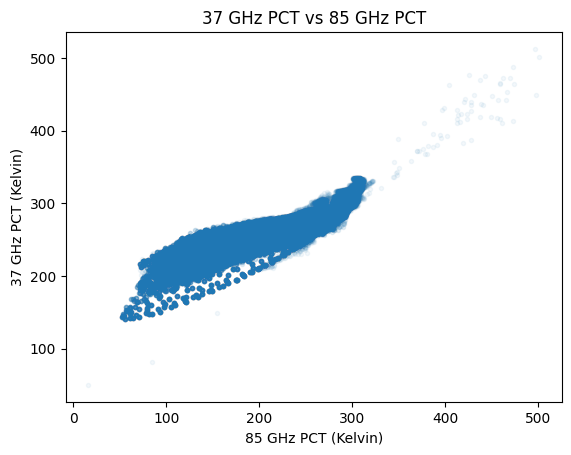

In [22]:
plt.plot(X[:,:,:,0].flatten(), y.flatten(), ".", alpha=0.05)
plt.title("37 GHz PCT vs 85 GHz PCT")
plt.xlabel("85 GHz PCT (Kelvin)")
plt.ylabel("37 GHz PCT (Kelvin)")

### Data filtering and transformation

In [23]:
x_test = X
y_test = y

In [24]:
y_test_transformed = y_test.flatten()

## 5.2. Load Model

### Skip if model was trained earlier. Ensure model is loaded into variable model

In [25]:
model_path = "/content/drive/MyDrive/NASA_Data/Models/_v5_freeze_off_cnn_model.h5"
model = load_model(model_path)

## 5.3. Evaluate Model

### 5.3.1. Performance Metrics

In [26]:
y_true = y_test_transformed
y_hat = model.predict(x_test, verbose=False).ravel()# predict on test data and flatten

mse, rmse, mae = compute_metrics(y_true, y_hat)
print("MAE Smoothed: ", mae)
print("RMSE Smoothed:", rmse)

MAE Smoothed:  3.6470407988546065
RMSE Smoothed: 5.220203581105334


### 5.3.2. Residual Plot

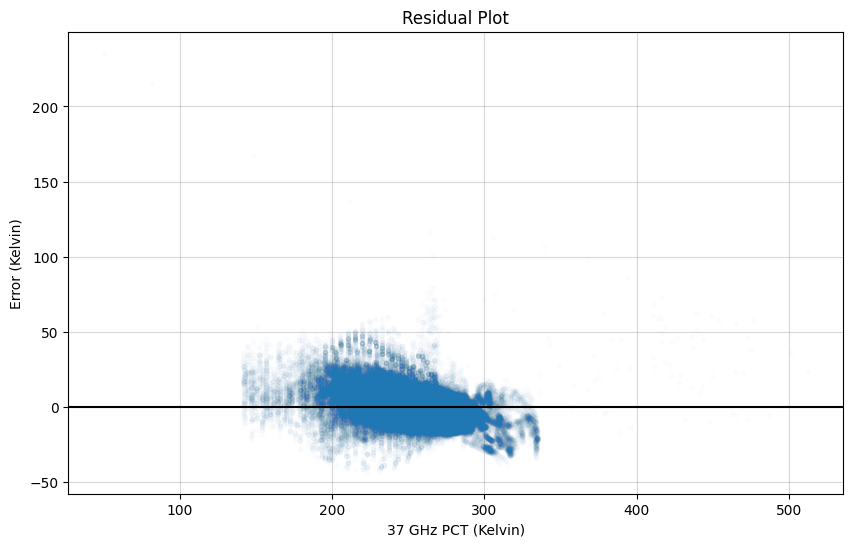

In [27]:
error = y_hat - y_true
plt.figure(figsize=(10, 6))
plt.title("Residual Plot")
plt.xlabel("37 GHz PCT (Kelvin)")
plt.ylabel("Error (Kelvin)")
plt.plot(y_true, error, ".", alpha=0.01)
plt.axhline(0, color="black")
plt.grid(alpha=0.5)

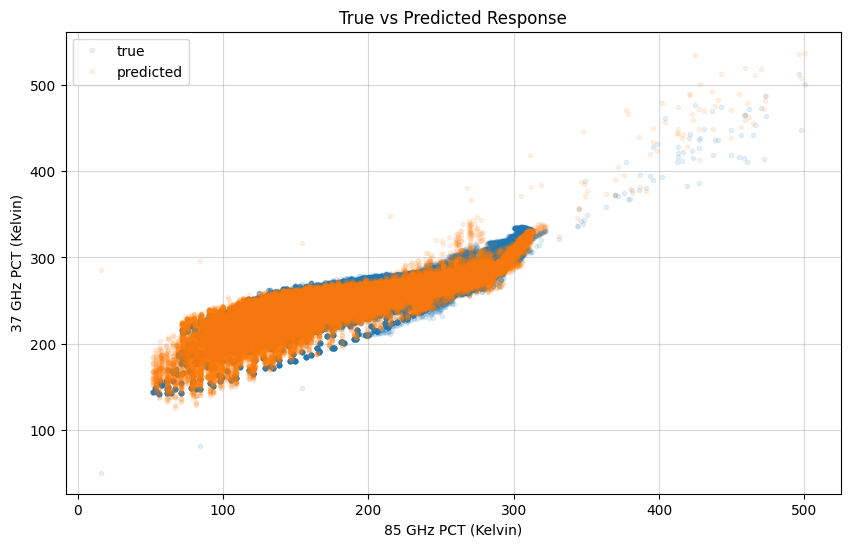

In [28]:
plt.figure(figsize=(10, 6))
plt.title("True vs Predicted Response")
plt.ylabel("37 GHz PCT (Kelvin)")
plt.xlabel("85 GHz PCT (Kelvin)")
plt.plot(x_test[:,:,:,0].flatten(), y_true, ".", alpha=0.1, label="true")
plt.plot(x_test[:,:,:,0].flatten(), y_hat, ".", alpha=0.1, label="predicted")
plt.grid(alpha=0.5)
plt.legend()

### 5.3.3. Error at Different Temperature Ranges

In [29]:
start = 140
stop = 280
step = 15
width = 30

In [30]:
data = []

thirty_seven = y_test_transformed

for i in range(start, stop-width, step):
    # filter
    high = i + width
    low = i

    freezing_mask_test = (thirty_seven < high) & (thirty_seven >= low)
    count = np.sum(freezing_mask_test)

    ## Test Error
    error = y_true[freezing_mask_test] - y_hat[freezing_mask_test]
    test_mae = np.mean(np.abs(error))
    test_rmse = np.sqrt(np.mean(np.square(error)))

    # Record
    data.append([low, high, count, test_mae, test_rmse])

data = np.array(data)

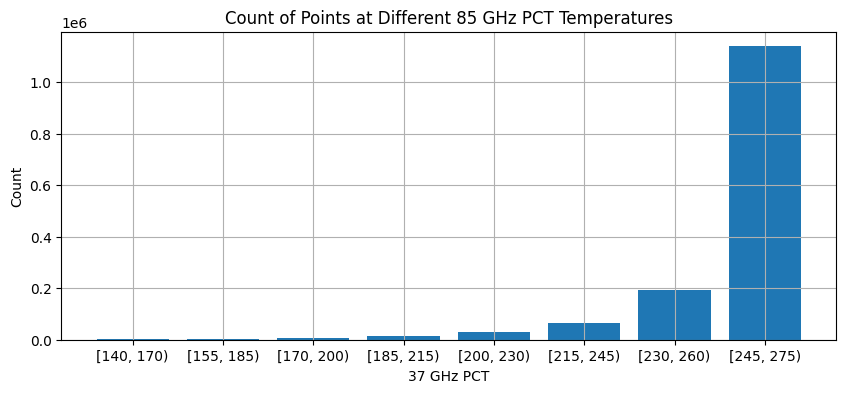

In [31]:
x_label = [f"[{int(x[0])}, {int(x[1])})" for x in data]
plt.figure(figsize=(10, 4))
plt.bar(x_label, data[:, 2])
plt.title("Count of Points at Different 85 GHz PCT Temperatures")
plt.xlabel("37 GHz PCT")
plt.ylabel("Count")
plt.grid()

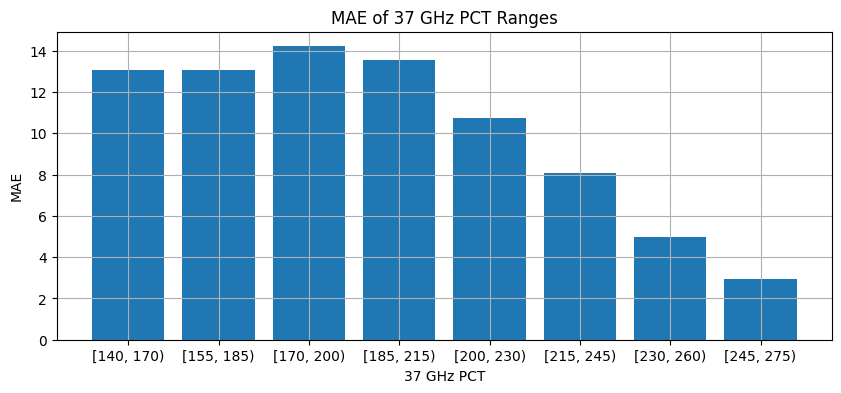

In [34]:
x_label = [f"[{int(x[0])}, {int(x[1])})" for x in data]
plt.figure(figsize=(10, 4))
plt.bar(x_label, data[:, 3])
plt.title("MAE of 37 GHz PCT Ranges")
plt.xlabel("37 GHz PCT")
plt.ylabel("MAE")
plt.yticks(range(0, 15, 2))
plt.grid()

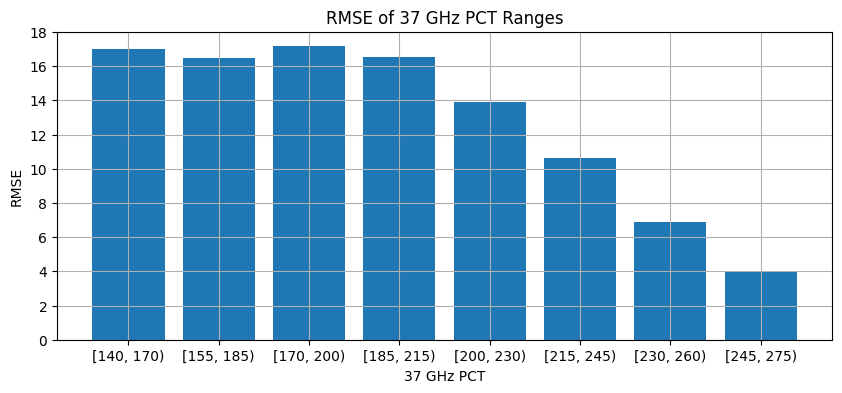

In [36]:
x_label = [f"[{int(x[0])}, {int(x[1])})" for x in data]
plt.figure(figsize=(10, 4))
plt.bar(x_label, data[:, 4])
plt.title("RMSE of 37 GHz PCT Ranges")
plt.xlabel("37 GHz PCT")
plt.ylabel("RMSE")
plt.yticks(range(0, 20, 2))
plt.grid()

### 5.3.4. Predicted vs Actual Images

In [37]:
preds = y_hat.reshape(-1, 16, 16)

In [38]:
start = 100
stop = 275
step = 25
width = 50

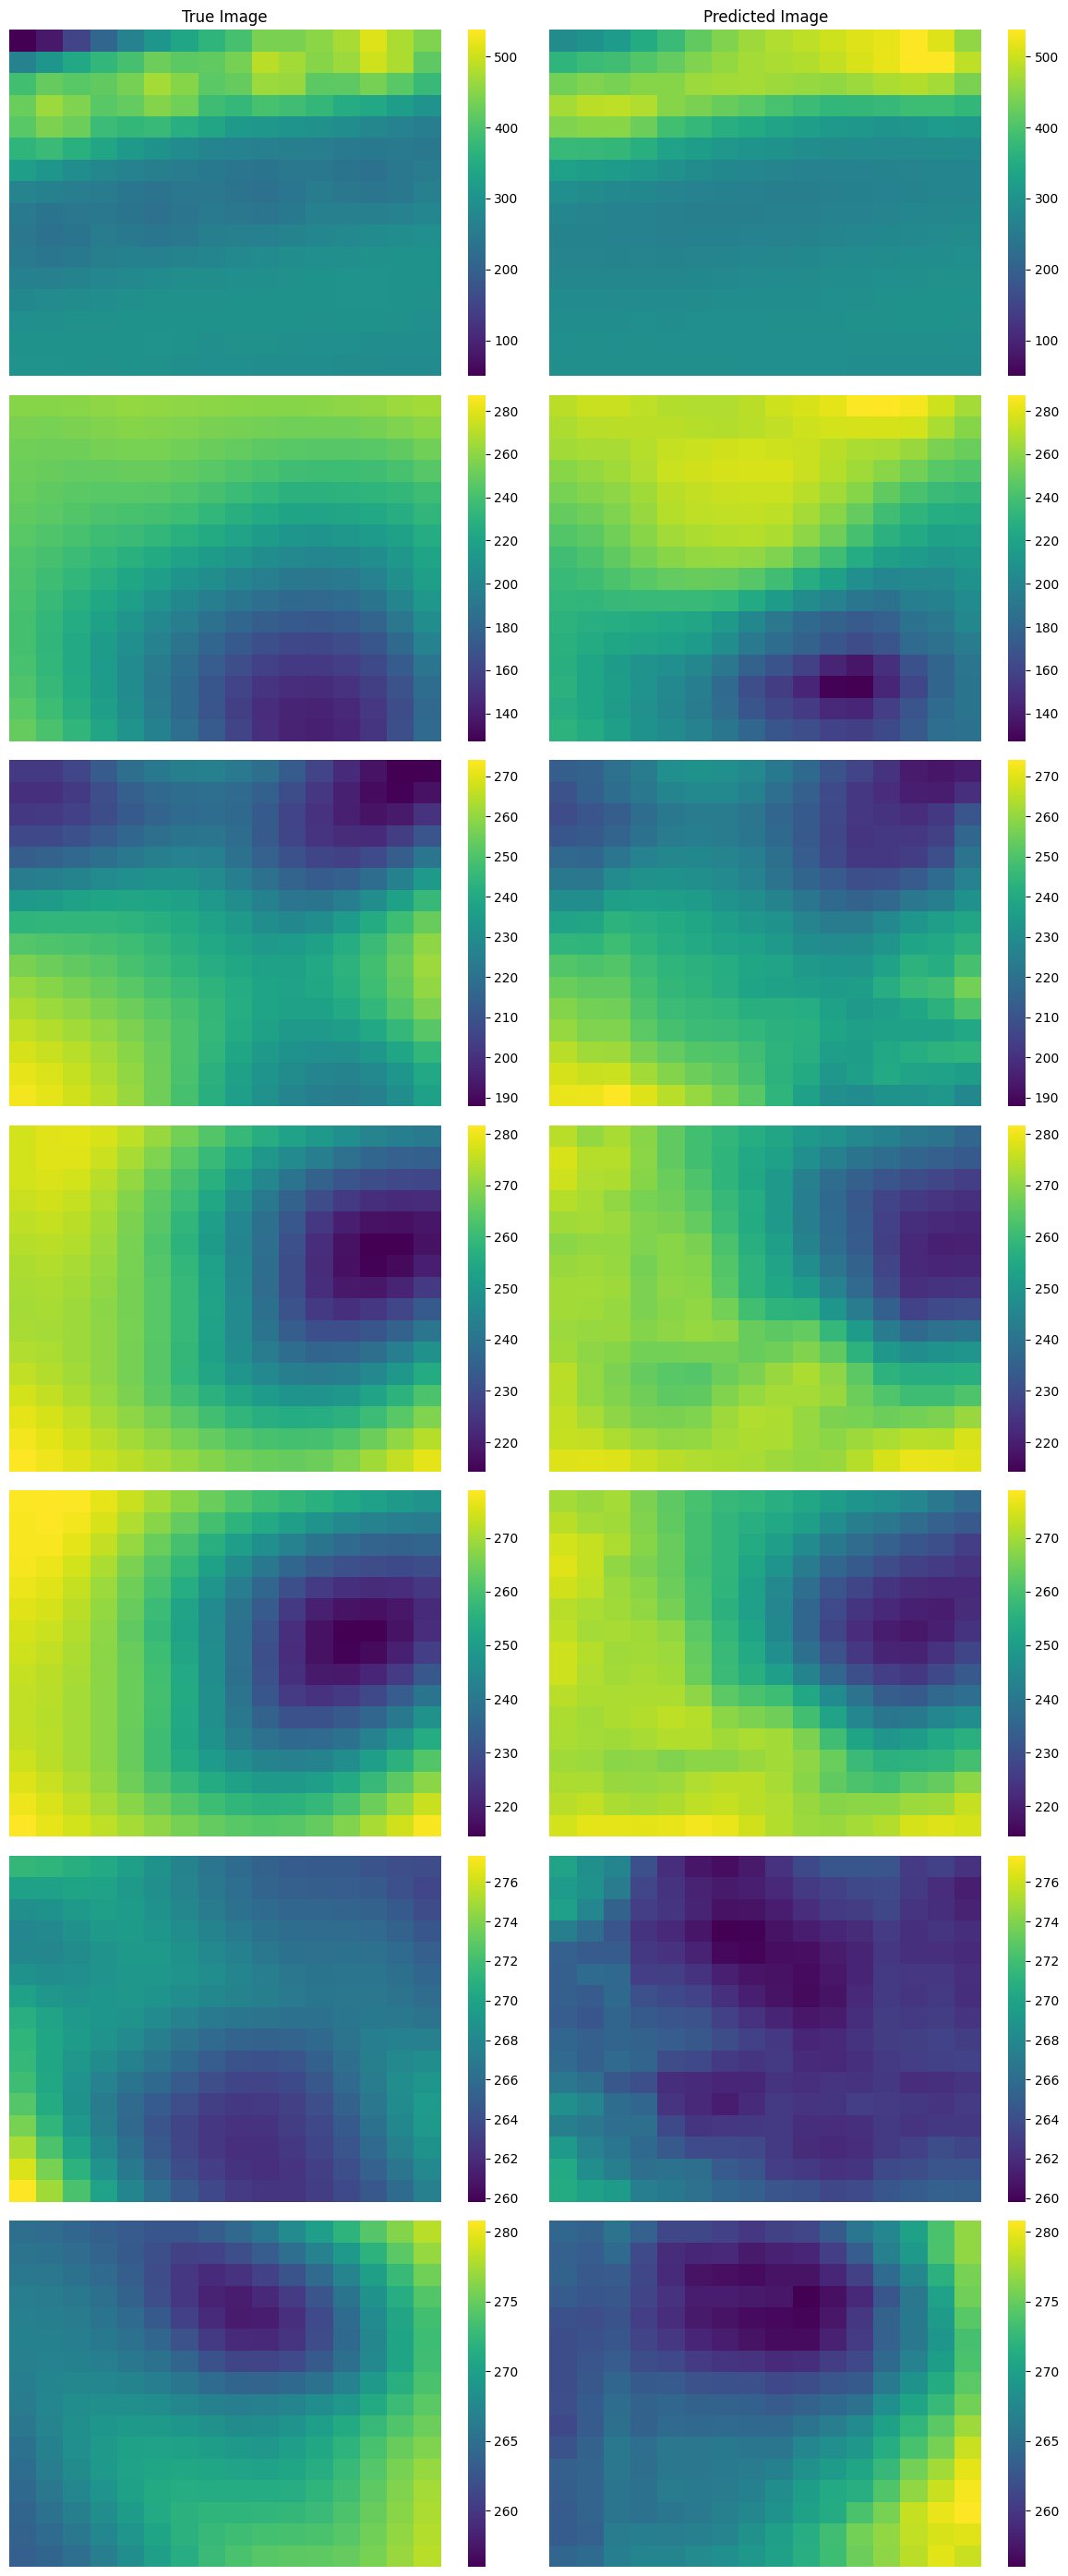

In [39]:
image_count = (stop - start) // step
fig, ax = plt.subplots(image_count, 2)
fig.set_figwidth(12)
fig.set_figheight(4 * image_count)

ax[0, 0].set_title("True Image")
ax[0, 1].set_title("Predicted Image")

for i, t in enumerate(range(start, stop, step)):
    temp_filter = np.any((y_test >= t) & (y_test < t+width), axis=(1,2))
    true_image = y_test[temp_filter][i]
    predicted_image = preds[temp_filter][i]
    vmin = np.min([np.min(true_image), np.min(predicted_image)])
    vmax = np.max([np.max(true_image), np.max(predicted_image)])
    sns.heatmap(true_image, ax=ax[i, 0], vmin=vmin, vmax=vmax, cmap="viridis")
    sns.heatmap(predicted_image, ax=ax[i, 1], vmin=vmin, vmax=vmax, cmap="viridis")
    ax[i,0].tick_params(
        left = False,
        right = False ,
        labelleft = False ,
        labelbottom = False,
        bottom = False
    )
    ax[i,1].tick_params(
        left = False,
        right = False ,
        labelleft = False ,
        labelbottom = False,
        bottom = False
    )
plt.tight_layout()